In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
import os

In [17]:
stock_name='AMZN'

In [18]:
def merge_data(stock_file, sentiment_file):
    """
    Merges stock data with sentiment data on the 'Date' column.

    Args:
    - stock_file (str): Path to the stock data CSV file.
    - sentiment_file (str): Path to the sentiment data CSV file.

    Returns:
    - pd.DataFrame: Merged dataset.
    """
    # Load stock and sentiment data
    stock_df = pd.read_csv(stock_file)
    sentiment_df = pd.read_csv(sentiment_file)

    # Ensure the 'Date' column is in the same format
    stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
    sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date']).dt.date

    # Merge the datasets on the 'Date' column
    merged_df = pd.merge(stock_df, sentiment_df, on='Date', how='left')
    return merged_df

# Example usage
stock_name = 'AMZN'
stock_file = f'./data/{stock_name}_data.csv'
sentiment_file = f'./data/{stock_name}_twitter_sentiment.csv'

# Merge stock and sentiment data
final_df = merge_data(stock_file, sentiment_file)
final_df.head()


,Date,Adj Close,Close,High,Low,Open,Volume,sentiment_score
0,2021-09-30,164.251999,164.251999,166.392502,163.699493,165.800003,56848000,0.246480
1,2021-10-01,164.162994,164.162994,165.458496,162.796997,164.450500,56712000,0.359337
2,2021-10-04,159.488998,159.488998,163.999496,158.812500,163.969498,90462000,0.258650
3,2021-10-05,161.050003,161.050003,163.036499,160.123001,160.225006,65384000,0.045500
4,2021-10-06,163.100494,163.100494,163.216995,159.931000,160.676498,50660000,0.194300


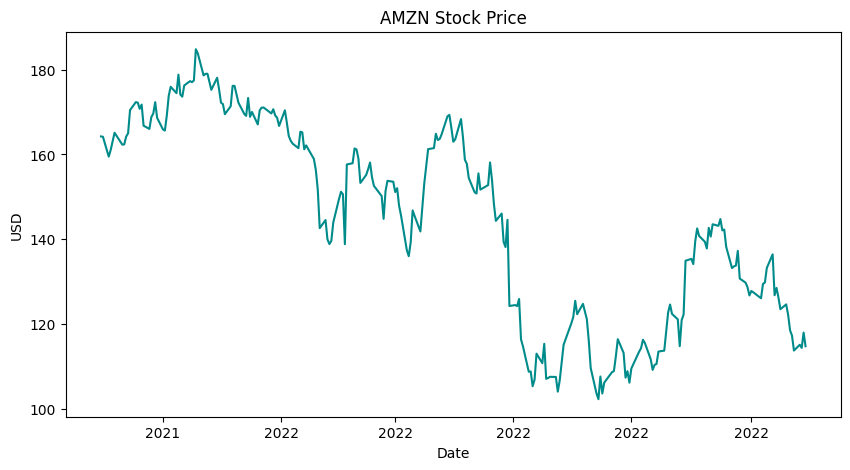

In [19]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the 'Close' prices against 'Date'
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')

# Set the labels and title of the plot
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")

# Format the x-axis to show the year
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# Display the plot
plt.show()


In [20]:
# Define stock name and file paths
stock_name = 'AMZN'
stock_file = f'./data/{stock_name}_data.csv'
sentiment_file = f'./data/{stock_name}_twitter_sentiment.csv'
target_column = 'Close'  # Column to predict

# Merge stock and sentiment data
final_df = merge_data(stock_file, sentiment_file)

# Display the first few rows of the merged dataframe
final_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,sentiment_score
0,2021-09-30,164.251999,164.251999,166.392502,163.699493,165.800003,56848000,0.246480
1,2021-10-01,164.162994,164.162994,165.458496,162.796997,164.450500,56712000,0.359337
2,2021-10-04,159.488998,159.488998,163.999496,158.812500,163.969498,90462000,0.258650
3,2021-10-05,161.050003,161.050003,163.036499,160.123001,160.225006,65384000,0.045500
4,2021-10-06,163.100494,163.100494,163.216995,159.931000,160.676498,50660000,0.194300


In [21]:
def get_tech_ind(data):
    """
    Calculate various technical indicators for stock data.
    This function adds several technical indicators to the input DataFrame, including:
    - 7-day moving average (MA7)
    - 20-day moving average (MA20)
    - Moving Average Convergence Divergence (MACD)
    - Bollinger Bands (upper_band and lower_band)
    - Exponential Moving Average (EMA)
    - LogMomentum (logmomentum)
    Parameters:
    data (pd.DataFrame): A DataFrame containing stock data with at least 5 columns, where the 5th column represents the closing price.
    Returns:
    pd.DataFrame: The input DataFrame with additional columns for each technical indicator.
    """
    # Calculate 7-day moving average
    data['MA7'] = data.iloc[:, 4].rolling(window=7).mean()  # Close column

    # Calculate 20-day moving average
    data['MA20'] = data.iloc[:, 4].rolling(window=20).mean()  # Close Column

    # Calculate MACD (Moving Average Convergence Divergence)
    data['MACD'] = data.iloc[:, 4].ewm(span=26).mean() - data.iloc[:, 1].ewm(span=12, adjust=False).mean()
    # This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential Moving Average (EMA)
    data['EMA'] = data.iloc[:, 4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:, 4] - 1)

    return data

In [22]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Adj Close,Close,High,Low,Open,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,172.328506,172.328506,173.949997,169.300003,170.104996,114174000,-0.001450,168.098570,165.189200,-2.423288,3.715605,172.620409,157.757990,168.854486,5.125748
1,2021-10-29,168.621506,168.621506,168.740997,163.666000,165.001007,129722000,0.140447,167.191071,165.232650,-2.646370,3.691159,172.614967,157.850333,165.395495,5.091699
2,2021-11-01,165.905502,165.905502,168.792999,164.600998,168.089996,72178000,0.373936,166.398357,165.522075,-2.345344,3.374624,172.271324,158.772826,164.865830,5.097431
3,2021-11-02,165.637497,165.637497,166.556000,164.177505,165.750504,52552000,0.336614,166.057286,165.724800,-2.093302,3.147343,172.019487,159.430113,164.406947,5.094839
4,2021-11-03,169.199997,169.199997,169.746002,164.876007,165.449997,67944000,0.260729,166.056002,165.972050,-2.375783,2.848262,171.668574,160.275527,164.719654,5.099110


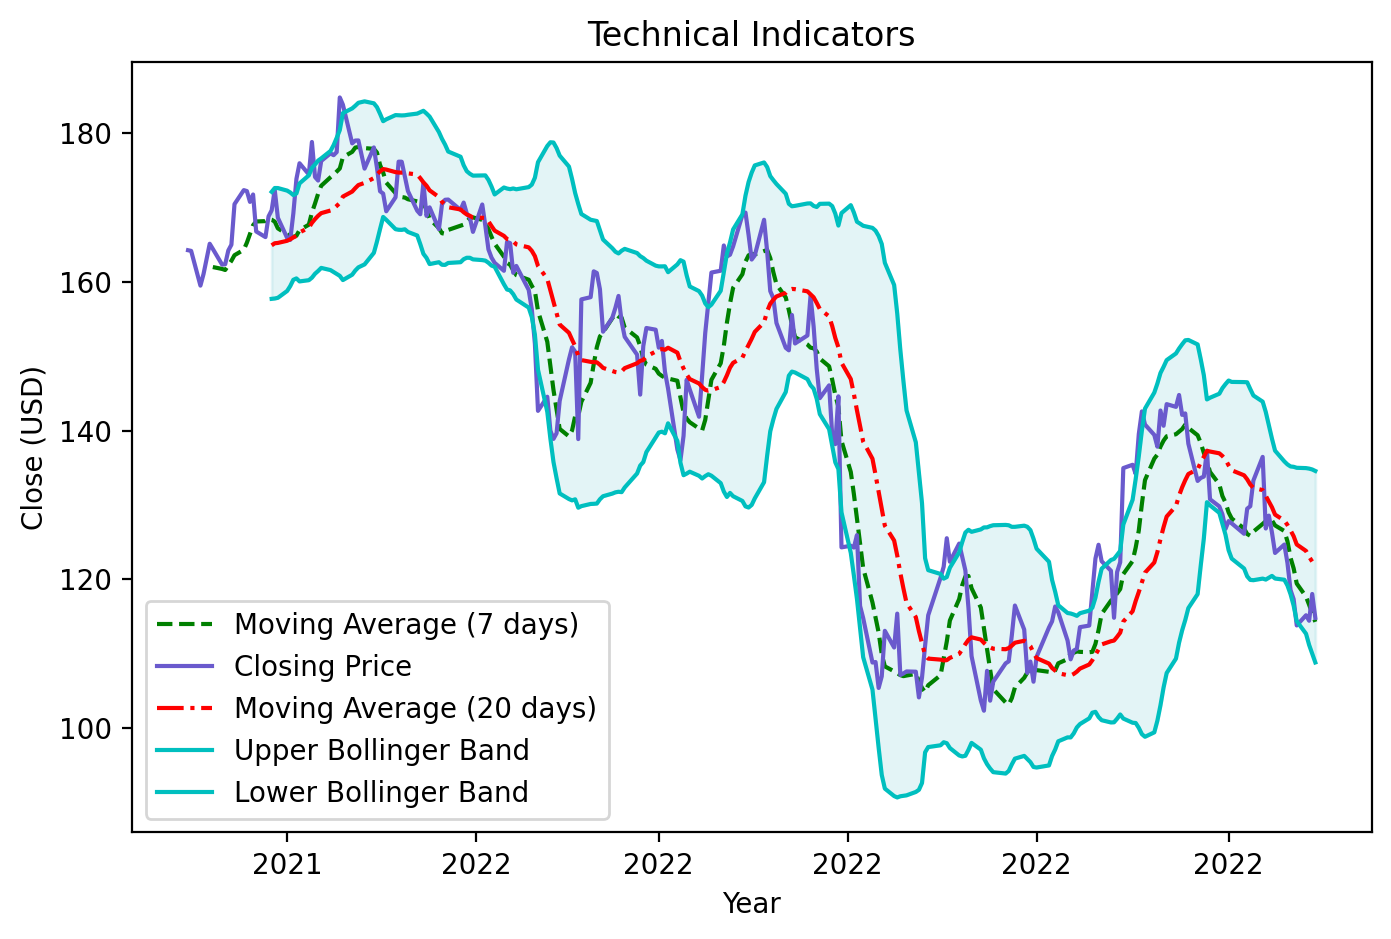

In [23]:
def tech_ind(dataset):
    """
    Plots various technical indicators for a given dataset.

    Parameters:
    dataset (DataFrame): A pandas DataFrame containing the stock data with the following columns:
        - 'Date': The date of the stock data.
        - 'MA7': 7-day moving average of the closing price.
        - 'Close': Closing price of the stock.
        - 'MA20': 20-day moving average of the closing price.
        - 'upper_band': Upper Bollinger Band.
        - 'lower_band': Lower Bollinger Band.

    Returns:
    None: This function only plots the graph and does not return any value.

    The function creates a plot with the following elements:
    - 7-day moving average (green dashed line)
    - Closing price (blue line)
    - 20-day moving average (red dash-dot line)
    - Upper Bollinger Band (cyan line)
    - Lower Bollinger Band (cyan line)
    - Shaded area between the upper and lower Bollinger Bands (light blue)

    The x-axis represents the date, formatted to show the year, and the y-axis represents the closing price in USD.
    """
    fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.plot(dataset['Date'], dataset['upper_band'], label='Upper Bollinger Band', color='c')
    ax.plot(dataset['Date'], dataset['lower_band'], label='Lower Bollinger Band', color='c')
    ax.fill_between(dataset['Date'], dataset['lower_band'], dataset['upper_band'], alpha=0.35, color='#B0E0E6')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical Indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()
    plt.show()

tech_ind(tech_df)


In [ ]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Adj Close,Close,High,Low,Open,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,172.328506,172.328506,173.949997,169.300003,170.104996,114174000,-0.001450,168.098570,165.189200,-2.423288,3.715605,172.620409,157.757990,168.854486,5.125748
1,2021-10-29,168.621506,168.621506,168.740997,163.666000,165.001007,129722000,0.140447,167.191071,165.232650,-2.646370,3.691159,172.614967,157.850333,165.395495,5.091699
2,2021-11-01,165.905502,165.905502,168.792999,164.600998,168.089996,72178000,0.373936,166.398357,165.522075,-2.345344,3.374624,172.271324,158.772826,164.865830,5.097431
3,2021-11-02,165.637497,165.637497,166.556000,164.177505,165.750504,52552000,0.336614,166.057286,165.724800,-2.093302,3.147343,172.019487,159.430113,164.406947,5.094839
4,2021-11-03,169.199997,169.199997,169.746002,164.876007,165.449997,67944000,0.260729,166.056002,165.972050,-2.375783,2.848262,171.668574,160.275527,164.719654,5.099110


In [ ]:
# def tech_ind(dataset):
#     """
#     Plots technical indicators for a given dataset.
#     This function creates a plot with various technical indicators such as 
#     Moving Averages (7 days and 20 days), Bollinger Bands, and Closing Price 
#     for the provided dataset. The plot is displayed with a title, axis labels, 
#     and a legend.
#     Parameters:
#     dataset (DataFrame): A pandas DataFrame containing the stock data with 
#                          columns 'Date', 'MA7', 'Close', 'MA20', 'upper_band', 
#                          and 'lower_band'.
#     Returns:
#     None
#     """
#     fig,ax = plt.subplots(figsize=(8, 5), dpi = 200)
#     x_ = range(3, dataset.shape[0])
#     x_ = list(dataset.index)

#     ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
#     ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
#     ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
#     ax.plot(dataset['Date'], dataset['upper_band'], label='Upper Bollinger Band', color='c')
#     ax.plot(dataset['Date'], dataset['lower_band'], label='Lower Bollinger Band', color='c')
#     ax.fill_between(dataset['Date'], dataset['lower_band'], dataset['upper_band'], alpha=0.35, color = '#B0E0E6')
#     ax.xaxis.set_major_formatter(DateFormatter("%Y"))
#     plt.title('Technical indicators')
#     plt.ylabel('Close (USD)')
#     plt.xlabel("Year")
#     plt.legend()

#     plt.show()

# tech_ind(tech_df)

NameError: name 'tech_df' is not defined

In [24]:
# Forward fill missing values in the dataset
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

# Convert 'Date' column to datetime
datetime_series = pd.to_datetime(dataset['Date'])

# Create a datetime index from the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

# Set the datetime index to the dataset
dataset = dataset.set_index(datetime_index)

# Sort the dataset by date
dataset = dataset.sort_values(by='Date')

# Drop the original 'Date' column as it's now the index
dataset = dataset.drop(columns='Date')

In [25]:
def normalize_data(df, range, target_column):
    """
    Normalize the data in a DataFrame using MinMaxScaler.
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data to be normalized.
    range (tuple): The desired range of the transformed data (min, max).
    target_column (str): The name of the target column to be normalized separately.
    Returns:
    tuple: A tuple containing two elements:
        - X_scale_dataset (np.ndarray): The normalized feature dataset.
        - y_scale_dataset (np.ndarray): The normalized target dataset.
    The function also saves the fitted scalers as 'X_scaler.pkl' and 'y_scaler.pkl' for future use.
    """
    
    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [26]:
def batch_data(x_data,y_data, batch_size, predict_period):
    """
    Batches the input and output data for time series prediction.
    Parameters:
    x_data (numpy.ndarray): The input data array of shape (n_samples, n_features).
    y_data (numpy.ndarray): The output data array of shape (n_samples, n_targets).
    batch_size (int): The number of samples per batch.
    predict_period (int): The number of future periods to predict.
    Returns:
    tuple: A tuple containing three numpy arrays:
        - X_batched (numpy.ndarray): The batched input data of shape (n_batches, batch_size, n_features).
        - y_batched (numpy.ndarray): The batched output data of shape (n_batches, predict_period).
        - yc (numpy.ndarray): The batched output data for the current period of shape (n_batches, batch_size, n_targets).
   
    """

    
    
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [27]:
def split_train_test(data, split_ratio = 0.8):
    """
        Splits the given dataset into training and testing sets.

        Parameters:
        data (list or array-like): The dataset to be split.
        split_ratio (float, optional): The ratio of the dataset to be used for training. Default is 0.8.

        Returns:
        tuple: A tuple containing the training set and the testing set.

    """

    #train_size = round(len(data) * split_ratio) #or
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [28]:
def predict_index(dataset, X_train, batch_size, prediction_period):
    """
    Generate indices for train and test predictions.
    This function calculates the indices for the training and testing prediction data
    based on the given dataset, training data, batch size, and prediction period.
    Parameters:
    dataset (pd.DataFrame): The entire dataset containing the data.
    X_train (pd.DataFrame or np.ndarray): The training data.
    batch_size (int): The size of the batch used in training.
    prediction_period (int): The number of periods to predict ahead.
    Returns:
    tuple: A tuple containing two elements:
        - train_predict_index (pd.Index): The indices for the training prediction data.
        - test_predict_index (pd.Index): The indices for the testing prediction data.
    """

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [29]:
# Normalize the dataset
X_scale_dataset, y_scale_dataset = normalize_data(dataset, (-1, 1), "Close")

# Batch the data
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size=5, predict_period=1)

# Print the shapes of the batched data
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

# Split the data into training and testing sets
X_train, X_test = split_train_test(X_batched)
y_train, y_test = split_train_test(y_batched)
yc_train, yc_test = split_train_test(yc)

# Generate indices for train and test predictions
index_train, index_test = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 15)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [30]:
# parameters
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

In [31]:
# Save the training and testing datasets
np.save('./data/X_train.npy', X_train)
np.save('./data/X_test.npy', X_test)
np.save('./data/y_train.npy', y_train)
np.save('./data/y_test.npy', y_test)
np.save('./data/yc_train.npy', yc_train)
np.save('./data/yc_test.npy', yc_test)
np.save('./data/index_train.npy', index_train)
np.save('./data/index_test.npy', index_test)